#### Load and Prepare Data

In [98]:
import torch
import torchvision
from torchvision import datasets, transforms
import tkinter as tk
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os


print(torch.__version__)

2.0.1+cpu


In [99]:
# Setup the data transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30, fill=(255, 255, 255)),
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

data_path = "images"
datasets = torchvision.datasets.ImageFolder(root = data_path, transform = transform)

data_loader = torch.utils.data.DataLoader(datasets, batch_size= 2, shuffle = True)

Label: Triangle


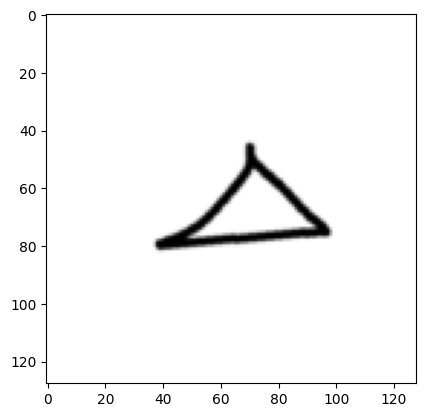

Label: Triangle


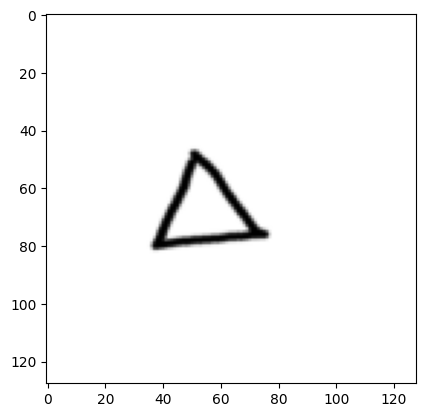

In [100]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Visualize images in the batch
for i in range(images.size(0)):
    print(f"Label: {datasets.classes[labels[i]]}")
    imshow(images[i])

In [ ]:
# Data Augmentation
img_num = 0

# Base directory for augmented images
augmented_base_dir = "augmented_images"

# Create a base directory for the augmented images if not exists
if not os.path.exists(augmented_base_dir):
    os.mkdir(augmented_base_dir)

for _ in range(500):
    for img, label in datasets:
        
        # Get the folder name from the label
        folder_name = [folder for folder, idx in datasets.class_to_idx.items() if idx == label][0]
        
        # Create a directory for each class inside augmented_images if it does not exist
        augmented_class_path = os.path.join("augmented_images", folder_name)
        if not os.path.exists(augmented_class_path):
            os.makedirs(augmented_class_path)
        
        # Save the augmented image
        torchvision.utils.save_image(img, os.path.join(augmented_class_path, 'img'+str(img_num)+'.png'))
        img_num += 1


In [102]:
# Update the working datasets
augmented_data_path = "augmented_images"
augmented_datasets = torchvision.datasets.ImageFolder(root = data_path, transform = transform)

augmented_data_loader = torch.utils.data.DataLoader(datasets, batch_size= 100, shuffle = True)

# Display class names and index labels for debug
print("Class names: ", augmented_datasets.classes)
print("Class index mapping:", augmented_datasets.class_to_idx)

Class names:  ['Square', 'Triangle']
Class index mapping: {'Square': 0, 'Triangle': 1}


In [103]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(augmented_datasets))
valid_size = len(augmented_datasets) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(augmented_datasets, [train_size, valid_size])

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle = False)


#### Define the Model

In [104]:
import torch.nn as nn
import torch.nn.functional as F

In [110]:
# Set up the neural net
class SimpleCNN(nn.Module):
    def __init__ (self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Note the change here from 3 to 1
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*8*8, 512)  
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x
    
num_classes = len(augmented_datasets.classes)
model = SimpleCNN(num_classes)

#### Specify Loss Function and Optimizer

In [111]:
lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


#### Train the Model

In [112]:
epochs = 100

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    if(epoch % 3 == 0):
        print(f"Epoch {epoch +1}/{epochs}, Loss: {train_loss: .4f}")

torch.save(model, "models/model1.pth")



RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x16384 and 4096x512)

#### Evaluate the Model

In [50]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 50.00%
Test Accuracy: 100.00%


#### Live Prediction

In [14]:
# Assuming the SimpleCNN class definition is already present
# model = torch.load('model/model1.pth')
# model.eval()

In [51]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Assuming 128x128 is the input size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard normalization values, adjust if yours are different
])

In [52]:

class DrawingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Prediction Board")

        self.canvas = tk.Canvas(root, bg="white", width=500, height=500)
        self.canvas.pack(pady=20)
        
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<ButtonRelease-1>", self.reset_last_coordinates)

        # Button to make predictions
        self.predict_button = tk.Button(root, text="Predict", command=self.predict)
        self.predict_button.pack(pady=20)

        # Button to clear the canvas
        self.clear_button = tk.Button(root, text="Clear", command=self.clear_screen)
        self.clear_button.pack(pady=20)

        self.last_x, self.last_y = None, None
        self.filename = 0

    def paint(self, event):
        x, y = event.x, event.y
        if self.last_x and self.last_y:
            self.canvas.create_line((self.last_x, self.last_y, x, y), width=10, fill='black', capstyle=tk.ROUND, smooth=tk.TRUE)
        self.last_x, self.last_y = x, y

    def reset_last_coordinates(self, event):  
        self.last_x, self.last_y = None, None

    def clear_screen(self):
        self.canvas.delete("all")

    def predict(self):
        # Capture the canvas content and convert it to a PIL Image
        x = self.root.winfo_rootx() + self.canvas.winfo_x()
        y = self.root.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()

        img = ImageGrab.grab(bbox=(x, y, x1, y1)).convert('RGB')
        
        # Transform the image and make a prediction
        img_tensor = transform(img).unsqueeze(0)
        
        with torch.no_grad():
            output = model(img_tensor)
            prediction = output.argmax(dim=1).item()
        
        # Display the prediction (assuming you have a variable "augmented_datasets" that holds class names)
        print(f"Predicted Class: {augmented_datasets.classes[prediction]}")
        
        probability = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probability, dim=1)
        confidence = probability[0][predicted_class].item()
        print(f"Confidence: {confidence}")

In [55]:
if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()

Predicted Class: Triangle
Confidence: 0.9999963045120239
